In [1]:
import os 
import torch
from data_loaders import dataset_loader
from sklearn.preprocessing import scale
from functions import *
from sensibility_structure import * 
import matplotlib.pyplot as plt
from mDAE_function import * 
from fancyimpute import KNN
from softimpute import softimpute, cv_softimpute
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from gain import gain
from imputers import OTimputer
from run_tdm import run_TDM

2024-04-09 14:43:06.852664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 14:43:07.608838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


/home/mdupuy/.local/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="6"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# mDAE versus the other baselines

In this notebook we give the methodolgy to get the same graphics than in our article. This notebook is composed of all the code needed of all the competitive methods tested in the article. 
To do this, we need a true dataset in which we will put artificial missing data. 

## Data and missing data

In [3]:
if not os.path.isdir("datasets"):
    os.mkdir("datasets")

name_data = "breast_cancer_diagnostic"

ground_truth = scale(dataset_loader(name_data)) # "breast_cancer_diagnostic" can be replaced with any of the datasets
                                             # supported by dataset_loader (see data_loaders.py)
#ground_truth = dataset_loader("libras")
X_true = torch.from_numpy(ground_truth)
X_true = X_true.float()
X_true = X_true.to(device)

Now we can put artificially missing data. In the article we propose 4 ways to generate missing data. We choose to use the same generation strategy detailed in https://github.com/BorisMuzellec/MissingDataOT for MAR and MNAR. 
For each mechanism you need to initialize some variables. The explanation of MAR and MNAR are in github cited previously. 
Overall you need the percent of missing data to put in the dataset, the number of columns and the number of rows. 

The outputs of these functions are : 
<ul>
  <li> <b>x</b> : the dataset pre-imputed by 0 (mean of the columns). The neural networks do not take datasets with NA's as input so we need to make pre-imputation </li>
  <li> <b>nb_cases_na</b> : number of elements chosen to be NA </li>
  <li> <b>ind_rows_na</b> and <b>ind_columns_na</b> : the indices of the two list at the same position give the position of missing data in <b>x</b> </li>
  <li> <b>list_no_na_col</b> : each row of this tab give the position of an element that have not be chosen to be NA </li>
</ul>

In [4]:
version_NA = "MCAR" #choose the kind of missing data you have to generate 
m = 0.2 #percent of missing data generated 
nb_col = X_true.size(1) 
nb_rows = X_true.size(0)

# x has the same values as X_true except a subset have been replace with 0 (pre-imputation of NA)

if version_NA == "MCAR" : 
    x, nb_cases_na, ind_rows_na, ind_columns_na, list_no_na_col = missing_data_MCAR(X_true,m,nb_col,nb_rows)

if version_NA == "MAR":
    x, nb_cases_na, ind_rows_na, ind_columns_na, list_no_na_col = missing_data_MAR(X_true, m, prop_var, nb_col, nb_rows)

if version_NA == "MNAR" : 
    x, nb_cases_na, ind_rows_na, ind_columns_na, list_no_na_col = missing_data_MNAR(X_true, m, prop_var, nb_col, nb_rows, exclude_inputs = True)

if version_NA == "blocks" : 
    x, nb_cases_na, ind_rows_na, ind_columns_na, list_no_na_col = missing_data_blocks(X_true, m, taille_block, nb_col, nb_rows)

In [5]:
# x_withNA has the same values as X_true except a subset have been replace with NaN
x_withNA = x.clone()
x_withNA[ind_rows_na,ind_columns_na]= torch.nan 

## Parameters

Some parameters are repeated for the methods of deep learning. batch size, epochs and learning rate are equals. 

In [6]:
batch_size = 80 #change the value according to the size of the dataset 
learning_rate = 1e-3
epochs_mdae = 1000

For mdae and knn we propose a way to optimise the hyper parameters of each method. To do so we need a proportion of the data used for validation and a number of iterations needed to do the validation. 

In [7]:
prop_data_validation = 0.2 #proportion of the data used to optimize mu 
nb_iter = 1 #number of repetitions to optimize mu 

## mDAE

All the procedure to use the mDAE algorithm at its best is explained is the mDAE.ipynb notebook. 

In [8]:
#parameters for structure choice 
grid_mu = [0.05,0.1,0.2,0.3,0.4,0.5] #see in the article, mu is an hyper parameter optimized in the mDAE prodedure
nb_mu = len(grid_mu)

In [9]:
sensibility_struct(x, grid_mu, nb_iter,nb_rows,nb_col,nb_cases_na,ind_rows_na,ind_columns_na,list_no_na_col,prop_data_validation, epochs_mdae,batch_size,learning_rate)

mdae struct1 
mdae struct2 
mdae struct3 
mdae struct4 
mdae struct5 
mdae struct6 


In [10]:
#loading 
methods_bis = ["struct1", "struct2", "struct3", "struct4", "struct5", "struct6"]
dicto = {me : [] for me in methods_bis }

for me in methods_bis : 
    dicto[me].append(torch.load(f"data_boxplot_mdae_{me}.pt"))

In [11]:
#to compute the error between reconstruction and true values for each structure, we load true values 
data_boxplot_true= torch.zeros([nb_cases_na])
data_boxplot_true[:] = X_true[ind_rows_na,ind_columns_na]

In [12]:
dicto_height = {me : [None,None] for me in methods_bis }

for me in methods_bis : 
    a = torch.zeros([1])
    a[0] = (1/data_boxplot_true.shape[0])*(torch.abs(data_boxplot_true -  dicto[me][0]).sum())

    dicto_height[me][0] = torch.mean(a)
    dicto_height[me][1] = torch.std(a)
  
dicto_height = torch.tensor(list(dicto_height.values()))

/home/mdupuy/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/mdupuy/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/mdupuy/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


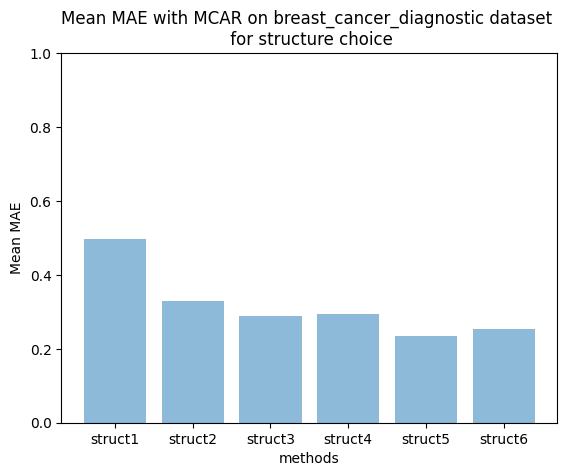

In [13]:
bars = ["struct1","struct2","struct3","struct4","struct5","struct6"]
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, dicto_height[:,0], yerr=dicto_height[:,1], align='center', alpha=0.5, ecolor='black', capsize=10)

# Add title and axis names
plt.title(f'Mean MAE with {version_NA} on {name_data} dataset \n for structure choice')
plt.xlabel('methods')
plt.ylabel('Mean MAE')

plt.ylim(0,1)
# Create names on the x-axis
plt.xticks(y_pos, bars)

# Show graphic
plt.show()

In [14]:
number_structure = 5

In [15]:
#parameters for structure choice 
grid_mu = [0.05,0.1,0.2,0.3,0.4,0.5] #see in the article mu is an hyper parameter optimized in the mDAE prodedure
nb_mu = len(grid_mu)

In [16]:
x_imputed = mDAE(x, nb_col, nb_rows, nb_iter,prop_data_validation,list_no_na_col,ind_rows_na,ind_columns_na,epochs_mdae,batch_size,learning_rate, grid_mu,nb_cases_na,number_structure)

## kNN 

In [17]:
# parameters used for knn 
grille_K = [5,10,15,20] #different k tested to get the best results with this method 
nb_K = len(grille_K)

In [18]:
data_boxplot_knn = torch.zeros([nb_cases_na])

tab_opti_K = torch.zeros([nb_iter,nb_K])
v=0
for k in grille_K : 
    print(k)
    w=0
    for d in range(nb_iter) : 
        #this function choose locations in x that are not NA (considered as the test locations), to do the validation
        z_eval, nb_cases_naknn, ind_rows_eval, ind_columns_eval = corruption_zeros_data_nodouble_valid2(x,prop_data_validation, nb_col, nb_rows,ind_list=list_no_na_col)
        z_withNA_eval = x_withNA.clone()
        z_withNA_eval[ind_rows_eval,ind_columns_eval]= torch.nan 

        X_filled_knn = KNN(k=k).fit_transform(x_withNA.cpu())

        #test error 
        mask = torch.zeros([nb_rows,nb_col], device=device)
        mask[ind_rows_eval,ind_columns_eval]=1

        masked_z = x*mask
        masked_pred_eval = torch.from_numpy(X_filled_knn).to(device)*mask

        num_test_error = torch.sum((masked_z-masked_pred_eval)**2)
        den_test_error = torch.sum((masked_z)**2)

        test_error = num_test_error/den_test_error
        tab_opti_K[w,v] = test_error 
        w=w+1
    
    v=v+1 

K_moyen = torch.mean(tab_opti_K,0)

K_opti = grille_K[np.argmin(K_moyen.detach().cpu().numpy())]

# Use 3 nearest rows which have a feature to fill in each row's missing features
X_filled_knn = KNN(k=K_opti).fit_transform(x_withNA.cpu())


# for each method the values imputed by the method are put in a tab to use for results after. The results are only computed on the values at the positions of missing data 
data_boxplot_knn[:] = torch.from_numpy(X_filled_knn[ind_rows_na.cpu(),ind_columns_na.cpu()])
data_boxplot_knn = data_boxplot_knn.cpu().detach()

5
Imputing row 1/569 with 3 missing, elapsed time: 0.103
Imputing row 101/569 with 6 missing, elapsed time: 0.109
Imputing row 201/569 with 8 missing, elapsed time: 0.116
Imputing row 301/569 with 5 missing, elapsed time: 0.121
Imputing row 401/569 with 8 missing, elapsed time: 0.127
Imputing row 501/569 with 9 missing, elapsed time: 0.133
10
Imputing row 1/569 with 3 missing, elapsed time: 0.095
Imputing row 101/569 with 6 missing, elapsed time: 0.102
Imputing row 201/569 with 8 missing, elapsed time: 0.109
Imputing row 301/569 with 5 missing, elapsed time: 0.115
Imputing row 401/569 with 8 missing, elapsed time: 0.121
Imputing row 501/569 with 9 missing, elapsed time: 0.127
15
Imputing row 1/569 with 3 missing, elapsed time: 0.092
Imputing row 101/569 with 6 missing, elapsed time: 0.098
Imputing row 201/569 with 8 missing, elapsed time: 0.104
Imputing row 301/569 with 5 missing, elapsed time: 0.110
Imputing row 401/569 with 8 missing, elapsed time: 0.115
Imputing row 501/569 with 9 m

## softImpute (si)

In [19]:
data_boxplot_si = torch.zeros([nb_cases_na])

x_miss = x_withNA.cpu().numpy()

cv_error, grid_lambda = cv_softimpute(x_miss, grid_len=15)
lbda = grid_lambda[np.argmin(cv_error)]
soft_imp = softimpute((x_miss), lbda)[1]


data_boxplot_si[:] = torch.from_numpy(soft_imp[ind_rows_na.cpu(),ind_columns_na.cpu()])
data_boxplot_si = data_boxplot_si.cpu().detach()

## Imputation with Chained Equations via Bayesian Regression (br) 

In [20]:
data_boxplot_ice = torch.zeros([nb_cases_na])

ice_imp = IterativeImputer(random_state=0, max_iter=50).fit_transform(x_miss)

data_boxplot_ice[:] = torch.from_numpy(ice_imp[ind_rows_na.cpu(),ind_columns_na.cpu()])
data_boxplot_ice = data_boxplot_ice.cpu().detach()

## Imputation with Chained Equations via Random Forest (rf)

In [21]:
#parameters
n_estimators = 15

In [22]:
data_boxplot_mf = torch.zeros([nb_cases_na])

missforest = IterativeImputer(max_iter=5, estimator=ExtraTreesRegressor(n_estimators=n_estimators))
missforest.fit(x_miss)
xhat_mf = missforest.transform(x_miss)

data_boxplot_mf[:] = torch.from_numpy(xhat_mf[ind_rows_na.cpu(),ind_columns_na.cpu()])
data_boxplot_mf = data_boxplot_mf.cpu().detach()

/home/mdupuy/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## GAIN

In [23]:
gain_parameters = {'batch_size': batch_size,
        'hint_rate': 0.9,
        'alpha': 100,
        'iterations': 10000}

In [24]:
data_boxplot_gain = torch.zeros([nb_cases_na]) 

imputed_data_x = gain(x_miss, gain_parameters) 

data_boxplot_gain[:] = torch.from_numpy(imputed_data_x[ind_rows_na.cpu(),ind_columns_na.cpu()])
data_boxplot_gain = data_boxplot_gain.cpu().detach()

2024-04-09 15:40:43.330965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43374 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-04-09 15:40:43.333433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43490 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:1b:00.0, compute capability: 8.6
2024-04-09 15:40:43.335919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46540 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:60:00.0, compute capability: 8.6
2024-04-09 15:40:43.338247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 43490 MB memory:  -> device: 3, name: NVIDIA A40, pci bus id: 0000:61:00.0, compute capability: 8.6


## MIWAE

In [25]:
h = 128 # number of hidden units in (same for all MLPs)
d = 1 # dimension of the latent space
K = 20 # number of IS during training
bs = batch_size # batch size
n_epochs = epochs_mdae

In [26]:
data_boxplot_miwae = torch.zeros([nb_cases_na]) 

xhat = miwae(x_withNA,x,h,d,K,bs,n_epochs)

data_boxplot_miwae[:] = torch.from_numpy(xhat[ind_rows_na.cpu(),ind_columns_na.cpu()])
data_boxplot_miwae = data_boxplot_miwae.cpu().detach()

Epoch 1
MIWAE likelihood bound  -32.7578
-----
Epoch 101
MIWAE likelihood bound  -19.8833
-----
Epoch 201
MIWAE likelihood bound  -17.8307
-----
Epoch 301
MIWAE likelihood bound  -17.0763
-----
Epoch 401
MIWAE likelihood bound  -16.5838
-----
Epoch 501
MIWAE likelihood bound  -16.2767
-----
Epoch 601
MIWAE likelihood bound  -16.1972
-----
Epoch 701
MIWAE likelihood bound  -16.6603
-----
Epoch 801
MIWAE likelihood bound  -15.7917
-----
Epoch 901
MIWAE likelihood bound  -15.8116
-----


## Sinkhorn imputation - Algorithm 1 (ot)

In [27]:
n, d = x_withNA.shape
batchsize = batch_size   #128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = learning_rate
epsilon = pick_epsilon(x_withNA) # Set the regularization parameter as a multiple of the median distance, as per the paper.

In [28]:
data_boxplot_ot = torch.zeros([nb_cases_na])  

sk_imputer = OTimputer(eps=epsilon, batchsize=batchsize, lr=lr, niter=2000)

sk_imp, sk_maes, sk_rmses = sk_imputer.fit_transform(x_withNA.cpu().double(), verbose=True, report_interval=500, X_true=X_true.cpu().double())


data_boxplot_ot[:] = sk_imp[ind_rows_na.cpu(),ind_columns_na.cpu()]
data_boxplot_ot = data_boxplot_ot.cpu().detach()

## TDM

In [29]:
####### TDM ######

niter = 2000
batchsize = batch_size
lr = learning_rate
report_interval = 100
network_depth = 3
network_width = 3

In [30]:
data_boxplot_tdm = torch.zeros([nb_cases_na]) 

args = {'out_dir': name_data, 'niter': niter,
'batchsize': batchsize, 'lr': lr, 'network_width': network_width, 'network_depth': network_depth, 'report_interval': report_interval}


tdm = run_TDM(x_withNA, args, X_true)

data_boxplot_tdm[:] = tdm[ind_rows_na.cpu(),ind_columns_na.cpu()]
data_boxplot_tdm = data_boxplot_tdm.cpu().detach()

## Comparison plots 

In [31]:
#save all the data with the imputed values to plot the loss 
torch.save(data_boxplot_knn,f"data_boxplot_knn_{version_NA}_{name_data}_{m}.pt")
torch.save(data_boxplot_miwae,f"data_boxplot_miwae_{version_NA}_{name_data}_{m}.pt")
torch.save(data_boxplot_mf,f"data_boxplot_mf_{version_NA}_{name_data}_{m}.pt")
torch.save(data_boxplot_ot,f"data_boxplot_ot_{version_NA}_{name_data}_{m}.pt")
torch.save(data_boxplot_ice,f"data_boxplot_ice_{version_NA}_{name_data}_{m}.pt")
torch.save(data_boxplot_si,f"data_boxplot_si_{version_NA}_{name_data}_{m}.pt")
torch.save(data_boxplot_tdm,f"data_boxplot_tdm_{version_NA}_{name_data}_{m}.pt")
torch.save(data_boxplot_gain,f"data_boxplot_gain_{version_NA}_{name_data}_{m}.pt")

torch.save(data_boxplot_true,f"data_boxplot_true_{version_NA}_{name_data}_{m}.pt")

In [36]:
methods = ["true","mdae", "knn","si","ice","mf", "gain", "miwae","ot","tdm",]

In [40]:
dicto = {me : [] for me in methods } 
methods_bis =["true", "knn","si","ice","mf", "gain", "miwae","ot","tdm",] 


for me in methods_bis : 
    dicto[me].append(torch.load(f"data_boxplot_{me}_{version_NA}_{name_data}_{m}.pt"))

dicto["mdae"].append(torch.load("NA_reconstructed_from_mDAE.pt"))


In [41]:
dicto_height_graph = {me : [None,None] for me in methods } 

for me in methods : 
    a = torch.zeros([1])
    a[0] = (1/dicto['true'][0].shape[0])*(torch.abs(dicto['true'][0] -  dicto[me][0] ).sum())

    dicto_height_graph[me][0] = torch.mean(a)
    dicto_height_graph[me][1] = torch.std(a)

dicto_height = torch.tensor(list(dicto_height_graph.values())[1:])

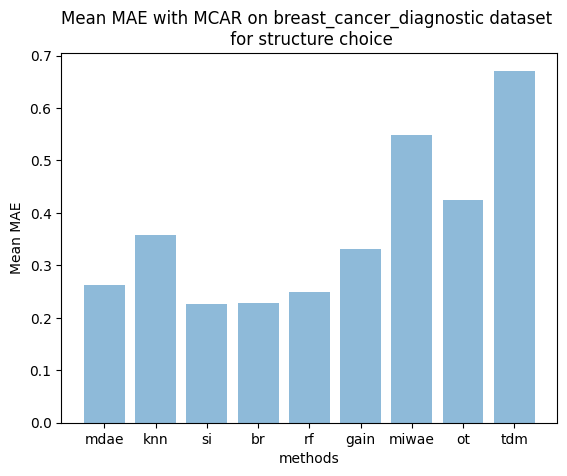

In [43]:
bars = ["mdae", "knn","si","br","rf", "gain", "miwae","ot","tdm",]

y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, dicto_height[:,0], yerr=dicto_height[:,1], align='center', alpha=0.5, ecolor='black', capsize=10)

# Add title and axis names
plt.title(f'Mean MAE with {version_NA} on {name_data} dataset')
plt.xlabel('methods')
plt.ylabel('Mean MAE')

#plt.ylim(0,1)
# Create names on the x-axis
plt.xticks(y_pos, bars)

# Show graphic
plt.show()